In [1]:
import torch
from IPython.display import display
from pathlib import Path
from PIL import Image
from jsonschema.exceptions import best_match
from torchvision import transforms
from gradcam import GradCAM
from gradcam.utils import visualize_cam

Set Device

In [2]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"

Load Image

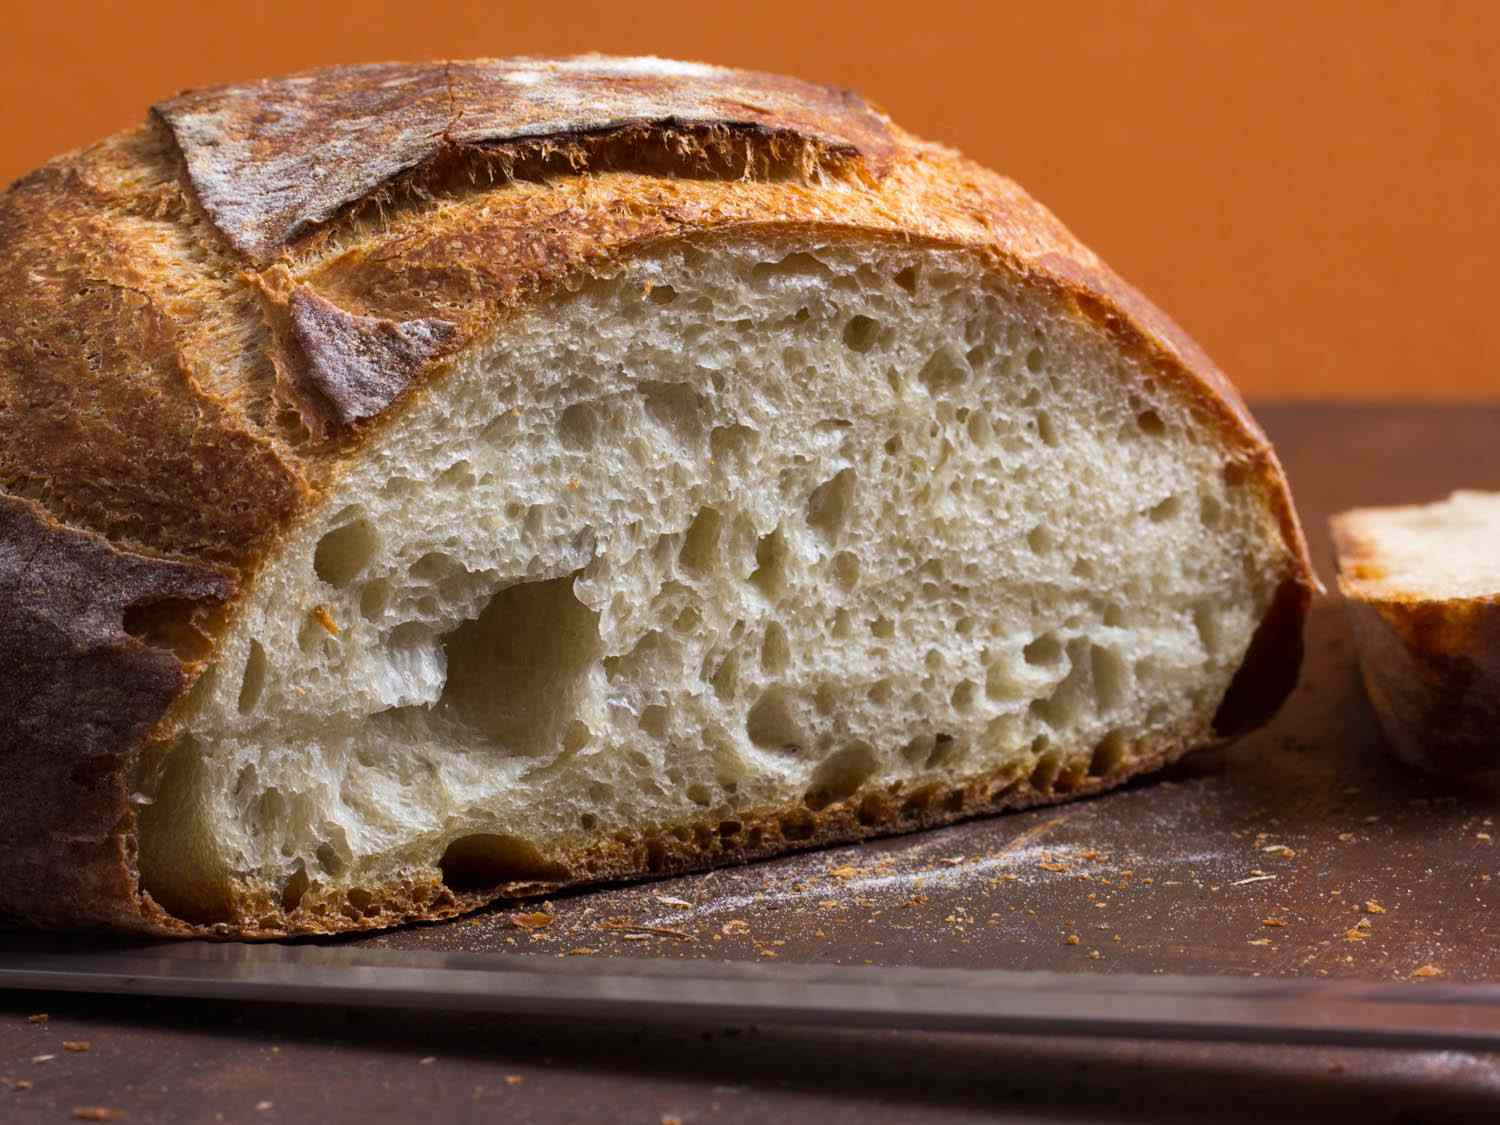

In [3]:
pil_img = Image.open('bread.jpg').convert('RGB')
pil_img

Preprocess Image

In [4]:
torch_img = transforms.Compose([transforms.Resize((224,224)),
                                transforms.ToTensor()])(pil_img).to(device)
norm_img  = transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))(torch_img)[None]

Load Model

In [5]:
best_models = [
    '../saved_models/Celery/ResNet/BatchSize 16/LR 0.0001/Celery.pt',
    '../saved_models/Cereals containing gluten/ResNet/BatchSize 64/LR 0.0001/Cereals containing gluten.pt',
    '../saved_models/Crustaceans/ResNet/BatchSize 16/LR 0.0001/Crustaceans.pt',
    '../saved_models/Eggs/ResNet/BatchSize 128/LR 0.0001/Eggs.pt',
    '../saved_models/Fish/ResNet/BatchSize 32/LR 0.0001/Fish.pt',
    '../saved_models/Milk/ResNet/BatchSize 32/LR 0.0001/Milk.pt',
    '../saved_models/Molluscs/ResNet/BatchSize 16/LR 0.0001/Molluscs.pt',
    '../saved_models/Mustard/ResNet/BatchSize 32/LR 0.001/Mustard.pt',
    '../saved_models/Nuts/ResNet/BatchSize 64/LR 0.0001/Nuts.pt',
    '../saved_models/Peanuts/ResNet/BatchSize 16/LR 0.0001/Peanuts.pt',
    '../saved_models/Sesame seeds/ResNet/BatchSize 16/LR 0.0001/Sesame seeds.pt',
    '../saved_models/Soybeans/ResNet/BatchSize 64/LR 0.0001/Soybeans.pt',
]

GradCam

C:\GitHub\FYP\.venv\Lib\site-packages\torch\nn\modules\module.py:1842: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
C:\GitHub\FYP\.venv\Lib\site-packages\gradcam\gradcam.py:81: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  saliency_map = F.upsample(saliency_map, size=(h, w), mode='bilinear', align_corners=False)


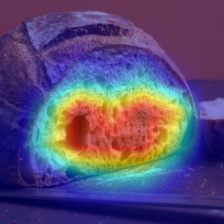

'Cereals containing gluten'

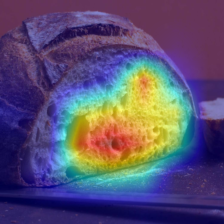

'Eggs'

In [6]:
cams = []
for mpath in best_models:
    model = torch.load(mpath, map_location=device, weights_only=False).eval()
    cam = GradCAM.from_config(model_type='resnet', arch=model, layer_name='layer4')

    output = model(norm_img)
    probabilities = torch.sigmoid(output)
    predictions = (probabilities > 0.5).int()

    if predictions.any():
        mask, _ = cam(norm_img)
        _, cam_img = visualize_cam(mask, torch_img)
        cams.append(cam_img.cpu())

        out_name = Path(mpath).stem
        img = transforms.ToPILImage()(cam_img)
        display(img, out_name)

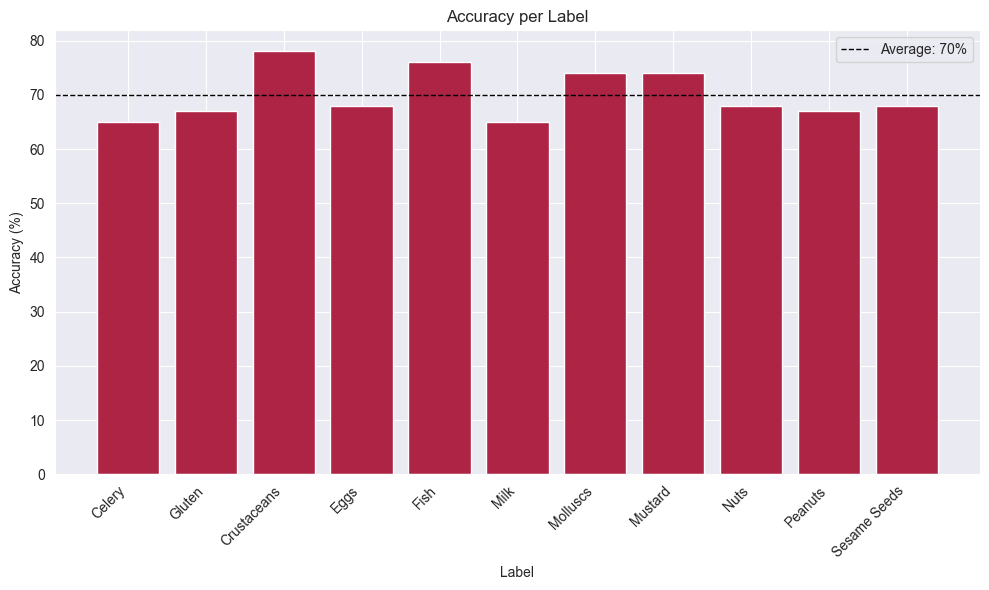

In [10]:
import numpy as np
import matplotlib.pyplot as plt

labels = ['Celery', 'Gluten', 'Crustaceans', 'Eggs', 'Fish', 'Milk', 'Molluscs', 'Mustard', 'Nuts', 'Peanuts', 'Sesame Seeds']
best_accuracies = [65, 67, 78, 68, 76, 65, 74, 74, 68, 67, 68]
color = '#AD2444'

plt.figure(figsize=(10, 6))
plt.bar(labels, best_accuracies, color=color)
plt.xlabel('Label')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy per Label')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

average_accuracy = np.mean(best_accuracies).astype(int)
plt.axhline(y=average_accuracy, color='black', linestyle='--', linewidth=1, label=f'Average: {average_accuracy}%')
plt.legend()
plt.show()